# Sensor manifold explanation

## 1. Sampling according to a cortical magnification function 

We will begin with some foundations here, before we move into the use of the `fovi` package. This will help you understand what you are actually doing.

The first key idea is that of cortical magnification -- the amount of V1 (in mm) taken up by a fixed amount of visual space (in deg). We will consider 1D cortical magnification, since cortical magnification depends mainly on eccentricity and is otherwise locally isotropic -- that is, it is the same when measuring as a function of eccentricity or polar angle. 

We use the cortical magnification function:

$M(r)=\frac{1}{r+a}$

Where $r$ is the radius or eccentricity, and $a$ is a hyperparameter that controls the degree of foveation (smaller = stronger foveation). We will visualize a range of CMFs across $a$ values later.

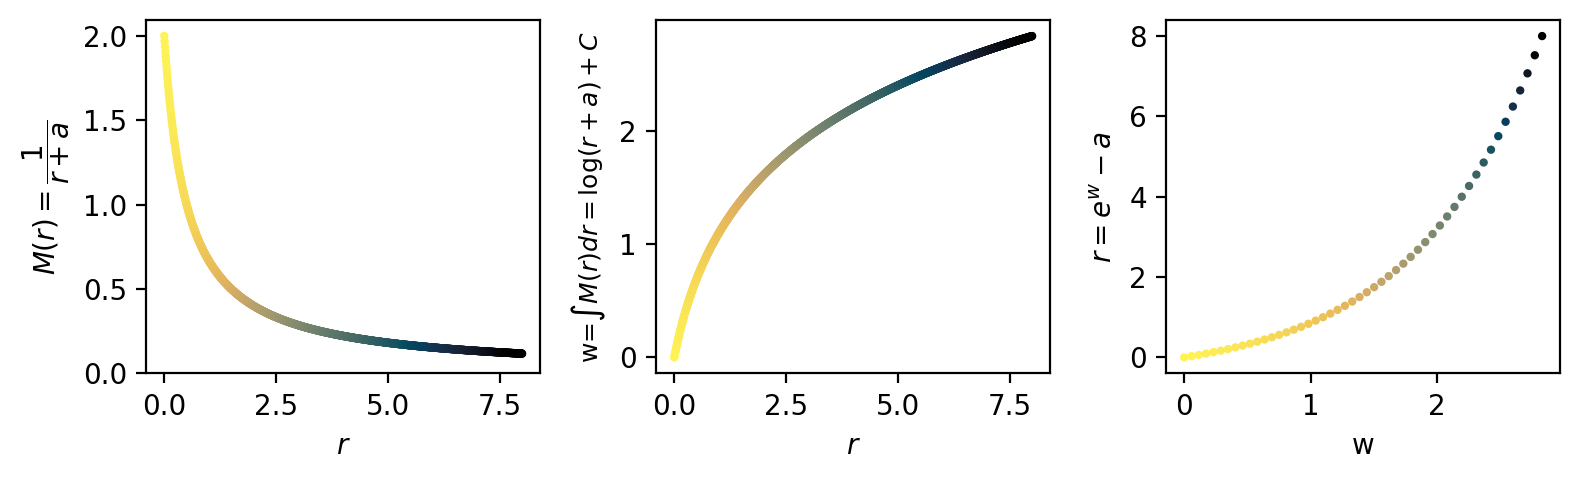

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr

fov = 16 # field-of-view diameter
max_rad = fov/2 # field-of-view radis
cmf_a = 0.5 # foveation hyperparameter
k = 1 # unimportant scaling factor; used when modeling actual V1 size
num_points = 50 # number of samples to take along the eccentricity dimension

def cmf(r, a, k):
    """
    cortical magnification function
    r: radius
    a: foveal radius
    k: scaling factor
    """
    return k/(r+a)

def cmf_integral(r, a, k):
    """
    integral of the cmf
    """
    return k*np.log(r+a)

def r_from_w(w, a, k):
    """
    solve visual field radius from log-radius
    """
    return np.exp(w/k) - a

r = np.linspace(0, max_rad, 1000) # not critical to sample with num_points here, this is just to get the shape of the curve
m_w = cmf(r, cmf_a, k)
w = cmf_integral(r, cmf_a, k)
samp_w = np.linspace(np.min(w),np.max(w),num_points)
new_r = r_from_w(samp_w, cmf_a, k)

# compute w-shift (this is the +C missing from our integral solution)
c = -samp_w.min()
samp_w = samp_w + c
w = w + c

s=4

# drop units
fig, axs = plt.subplots(1, 3, figsize=(8,2.5), dpi=200)

ax = axs[0]
ax.scatter(r, m_w, c=r, cmap='cmr.eclipse_r', s=s)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$M(r)=\dfrac{1}{r+a}$')
# ax.axvline(0.5, 0, 1, color='k', linestyle='--', linewidth=0.5)
# ax.text(0.15, 0.9, r'$r=a=0.5$', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.set_ylim(bottom=0)

ax = axs[1]
ax.scatter(r, w, c=r, cmap='cmr.eclipse_r', s=s)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'w=$\int M(r) dr=\log(r+a) + C$', fontsize=9)

ax = axs[2]
ax.scatter(samp_w, new_r, alpha=1, s=s, c=new_r, cmap='cmr.eclipse_r')
ax.set_xlabel(r'w')
ax.set_ylabel(r'$r=e^w-a$')
plt.tight_layout()
plt.show()

## 1b. Variable foveation via variable cortical magnification

We can create a spectrum of foveated sensors by varying the foveal diameter $a$ given fixed total resources.

Here, we normalize the CMF using a constant $k_a$, where $k_a = \left(\int_0^{r_{\text{max}}} \frac{1}{r+a}\,dr\right)^{-1}$, in order to normalize the area-under-the-curve across models.

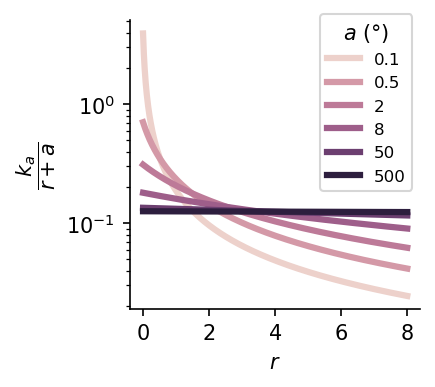

In [2]:
import pandas as pd
import seaborn as sns
df = {'cmf_a':[], 'r':[], 'm_r':[], 'log_cmf_a':[]}
for cmf_a in [0.05, 0.5, 2, 8, 50, 500]:
    r = np.linspace(0, max_rad, 1000) # not critical to sample with num_points here, this is just to get the shape of the curve
    m_r = cmf(r, cmf_a, k)
    # normalize m_r to have unit AUC
    auc = cmf_integral(max_rad, cmf_a, 1) - cmf_integral(0, cmf_a, 1)
    m_r = cmf(r, cmf_a, 1/auc)
    for r_i, m_r_i in zip(r, m_r):
        df['cmf_a'].append(cmf_a)
        df['r'].append(r_i)
        df['m_r'].append(m_r_i)
        df['log_cmf_a'].append(np.log(cmf_a))
df = pd.DataFrame(df)

plt.figure(figsize=(2.5,2.5), dpi=150)
sns.lineplot(data=df, x='r', y='m_r', hue='log_cmf_a', linewidth=3)
handles, labels = plt.gca().get_legend_handles_labels()
# Replace log_cmf_a labels with actual cmf_a values
new_labels = []
for l in labels:
    try:
        # log_cmf_a is used as hue, so l is a float string of log(cmf_a)
        log_cmf_a = float(l)
        cmf_a_val = np.exp(log_cmf_a)
        # Format nicely, e.g. 0.1, 1, 4, 16, 100, 1000
        if cmf_a_val < 1:
            label_str = f"{cmf_a_val:.1f}"
        else:
            label_str = f"{int(np.round(cmf_a_val)):d}"
        # if np.abs(cmf_a_val - 500) < 0.01:
        #     label_str += ' (uniform)'
        new_labels.append(label_str)
    except Exception:
        new_labels.append(l)
plt.legend(handles, new_labels, title='$a$ (°)', fontsize=8, bbox_to_anchor=[1,1.05], loc='upper right')
plt.xticks([0,2,4,6,8])
plt.yscale('log')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('$r$')
plt.ylabel(r'$\dfrac{k_a}{r+a}$')
plt.show()

## 2. Locally isotropic sampling of angles

We just showed how to sample eccentricity values. The next step is to sample some number of angles at each eccentricity, such that the distance between angular points is approximately the same as the distance between eccentricity points. This satisfies our desire for locally isotropic sampling.

In [3]:
import torch

fov = 16
cmf_a = 0.5

num_points = 10

# r_delta = max_rad / num_points
r = np.linspace(0, max_rad, 1000) # not critical to sample with num_points here, this is just to get the shape of the curve
m_w = cmf(r, cmf_a, k)
w = cmf_integral(r, cmf_a, k)
w_delta = (np.max(w) - np.min(w))/(num_points-1)
samp_w = np.linspace(np.min(w),np.max(w)+w_delta,num_points+1, endpoint=True)
radii = r_from_w(samp_w, cmf_a, k)

# fulfill approximate isotropy: make the difference between neighboring angles equal to the difference in neighboring radii
n_angles_init = 1
n_angles = [n_angles_init]
all_angles = [[0]]
for ii in range(1, num_points):
    # average curr to prev and curr to next radius dists
    radius_diff = ((radii[ii] - radii[ii-1]) + (radii[ii+1] - radii[ii])) / 2 

    # determine the number of angles s.t. arc length distance between points is close to radius_diff
    n_angles_ii = len(torch.arange(0,2*torch.pi*radii[ii],radius_diff))
    n_angles.append(n_angles_ii)
    # now ensure even spacing
    angles = np.linspace(0, 2*np.pi, n_angles_ii, endpoint=False)
    all_angles.append(angles)
n_angles = torch.tensor(n_angles)  

# remove extra radius
radii = radii[:-1]

Given the number of angles at each radius, we can now create our sampling grid

In [4]:
samples = []
for ii, rad_i in enumerate(radii):
    angles = all_angles[ii]
    for angle in angles:
        x = rad_i*np.cos(angle)
        y = rad_i*np.sin(angle)
        samples.append(np.array([x, y]))
samples = np.stack(samples, 0)

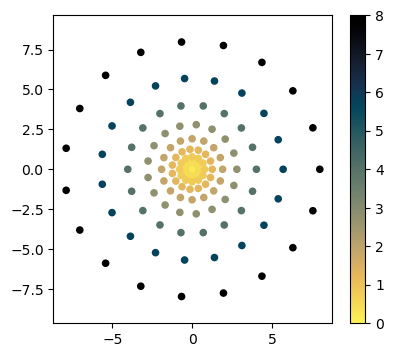

In [5]:
plt.figure(figsize=(4.5,4))
plt.scatter(x=samples[:,0], y=samples[:,1], s=20, alpha=1, c=np.sqrt(samples[:,0]**2 + samples[:,1]**2), cmap='cmr.eclipse_r')
plt.axis('equal')
plt.colorbar()
plt.show()

Normally, we would just use the SamplingCoords class for this. We will highlight this more in the next notebook.

Note that the Cartesian coordinates from SamplingCoords are normalized to lie between -1 and 1

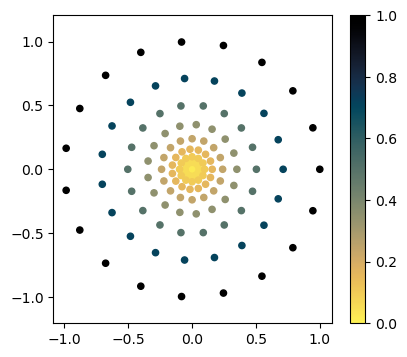

In [6]:
from fovi.sensing.coords import SamplingCoords

# coords, polar_coords, plotting_coords = get_isotropic_sampling_coords(fov, cmf_a, num_points)
coords = SamplingCoords(fov, cmf_a, num_points)

plt.figure(figsize=(4.5,4))
plt.scatter(x=coords.cartesian[:,0], y=coords.cartesian[:,1], c=coords.polar[:,0], cmap='cmr.eclipse_r', s=20, alpha=1)
plt.axis('equal')
plt.colorbar()
plt.show()

# Sensor manifold

Great, now we can move onto the key insight that allows us to do structured (e.g. convolutional) processing on this non-uniform array of samples. 

This insight is that we can expand these samples into a third dimension such that all points are equidistant to their neighbors. Thankfully, Rovamo & Virsu (1984) developed the mathematical framework for this. 

The 3-D coordinates in which this manifold lives are stored in coords.cortical.

Coordinate systems:
-  $(x, y)$ -> visual cartesian coordiantes (`coords.cartesian`)
-  $(r, \theta)$ -> visual polar coordinates (`coords.polar`)
-  $(\rho, z, \phi)$ -> cortical cylindrical coordinates (not stored, but used in `fovi.sensing.manifold`)
-  $(x_c, y_c, z_c)$ -> cortical cartesian coordinates (`coords.cortical`)

Diving into the math of the sensor manifold is beyond the scope of this notebook. However, if you are curious, I encourage you to check out the references as well a the `SensorManifold` class in `fovi.sensing.manifold` to see how this works in more detail. We use numerical methods to solve the equations for our particular cortical magnification function.

For now, we'll plot the manifold, and later, we'll learn how to do convolution on its surface

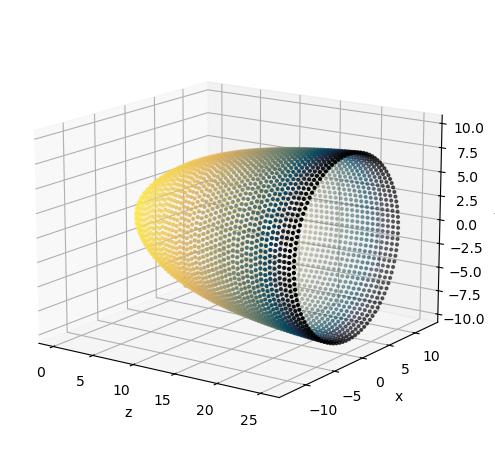

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import torch

cmf_a = 0.5
fov = 16
n_radii = 50

coords = SamplingCoords(fov, cmf_a, n_radii)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', azim=-55, elev=15)
scatter = ax.scatter(coords.cortical[:,2], coords.cortical[:,0], coords.cortical[:,1], s=4, c=coords.polar[:,0], cmap='cmr.eclipse_r')
ax.axis('equal')
# ax.axis('off')
plt.xlabel('z')
plt.ylabel('x')
plt.gca().set_zlabel('y')
plt.tight_layout()
plt.show()
plt.show()

Last, we'll provide some visual intuition for how the sensor manifold transforms from non-uniform density and no magnification, to uniform density with magnification

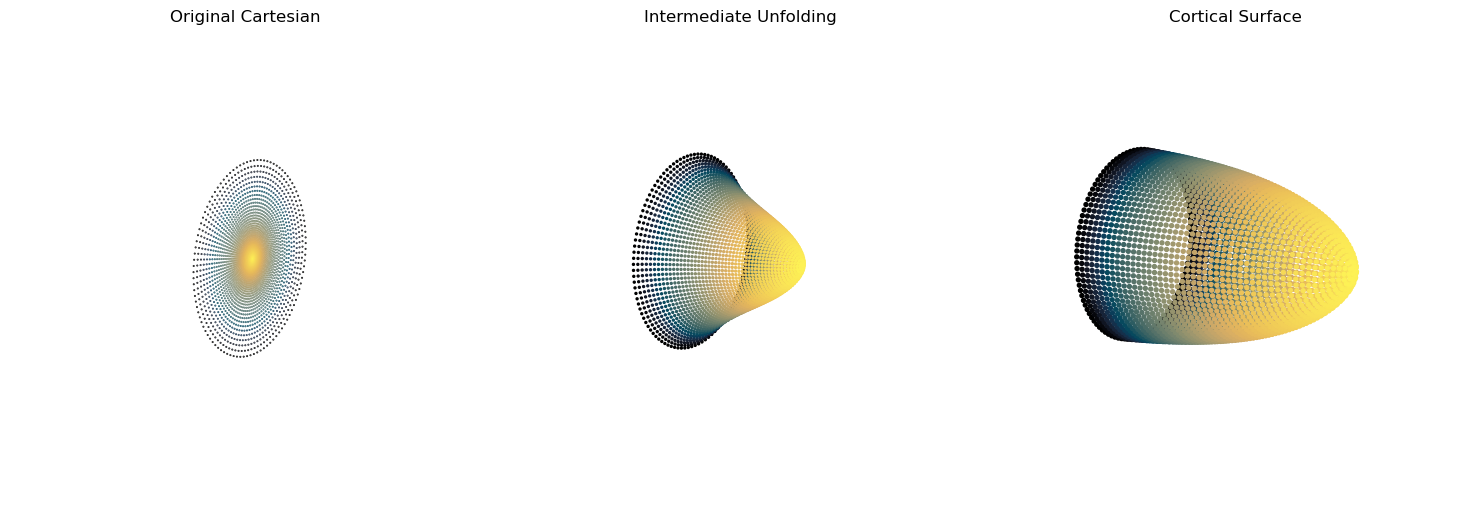

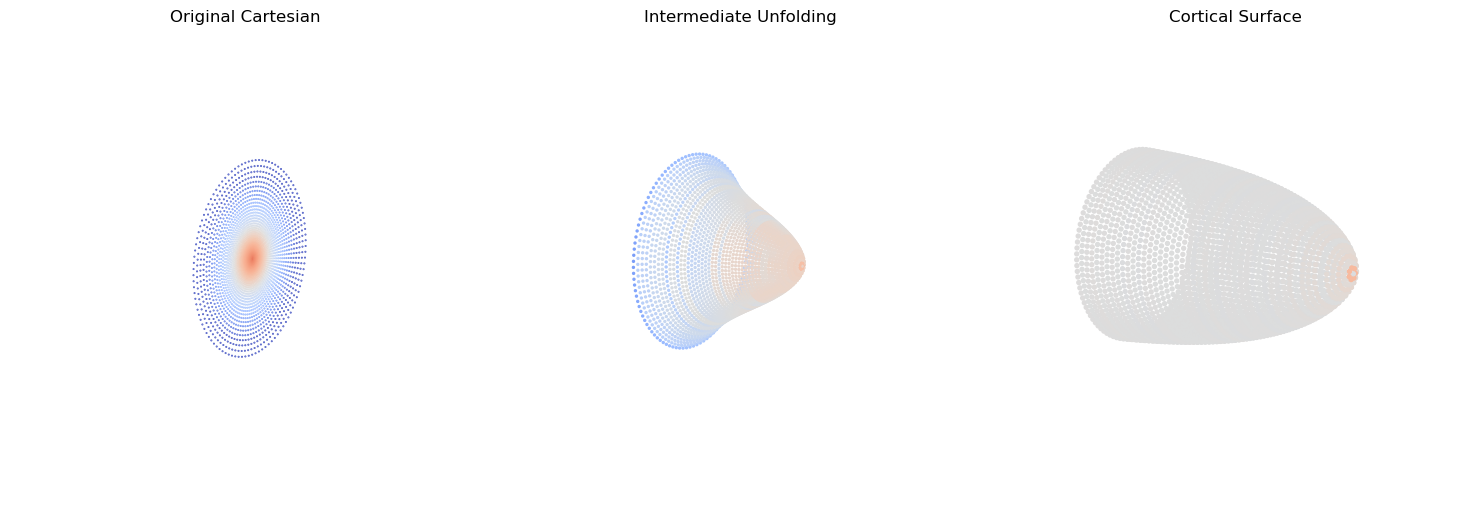

In [8]:
def blend(coords, alpha):
    """
    interpolate between cartesian and cortical coordinates
    """
    cart_3d = coords.cartesian
    cart_3d = torch.cat((cart_3d, torch.zeros(cart_3d.shape[0],1)),1)
    for ind in np.arange(2):
        cart_3d[:,ind] = torch.max(coords.cortical[:,ind])*cart_3d[:,ind]/torch.max(cart_3d[:,ind])
    # cart_3d = cart_3d/torch.max(cart_3d)*
    return (1-alpha)*cart_3d + (alpha)*coords.cortical

def local_density(coords, k=8, device='cuda'):
    """
    return average distance to k-nearest-neighbors
    """
    coords = coords.to(device)
    dists = torch.cdist(coords, coords)
    # dists[dists.argmin(0),:] = 100000
    dists, _ = torch.sort(dists, 0)
    dists = dists[1:k+1].mean(0).to('cpu')
    return -dists

def make_density_plot(ax, blended, cmap, s, elev=None, azim=None, roll=None, show_cbar=True):
    color = local_density(blended, k=1, device='cpu')
    color_range = initial_densityk1.max() - initial_densityk1.min()
    vmin=color.median() - color_range/2
    vmax=color.median() + color_range/2
    labels = ['Low density', 'High density']
    scatter = ax.scatter(blended[:,2], -blended[:,0], -blended[:,1], alpha=1, s=s, c=color, vmin=vmin, vmax=vmax, cmap=cmap)
    # add final alpha scatter invisibly to set bounds
    # ax.scatter(coords.cortical[:,2], coords.cortical[:,0], coords.cortical[:,1], alpha=0)
    if cmap is not None and show_cbar:
        cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, label=None) #, orientation='vertical')
        cbar.ax.set_xticks([])
        cbar.ax.set_yticks([vmin, vmax], labels)
    ax.view_init(elev=elev, azim=azim, roll=roll)
    ax.axis('equal')
    ax.axis('off')

sizes = [0.2, 2, 8]
# sizes = [4, 4 ,4]
initial_densityk1 = local_density(blend(coords, 0), k=1, device='cpu')

# transformation figure
for param_name, params in {
    'outer':dict(roll=177, elev=173, azim=304), 
    # 'inner':dict(azim=-55, elev=15, roll=0),
    }.items():
    fig = plt.figure(figsize=(15,5))
    blended = blend(coords, alpha=0)
    ax1 = fig.add_subplot(131, projection='3d', **params)
    scatter = ax1.scatter(blended[:,2], blended[:,0], blended[:,1], s=sizes[0], alpha=1, c=coords.polar[:,0], cmap='cmr.eclipse_r')
    ax1.axis('equal')
    ax1.axis('off')
    ax1.set_title('Original Cartesian')

    # intermediate unfolding
    blended = blend(coords, alpha=0.5) 
    ax2 = fig.add_subplot(132, projection='3d', **params)
    scatter = ax2.scatter(blended[:,2], blended[:,0], blended[:,1], s=sizes[1], alpha=1, c=coords.polar[:,0], cmap='cmr.eclipse_r')
    ax2.axis('equal')
    ax2.axis('off')
    ax2.set_title('Intermediate Unfolding')

    # cortical view
    ax3 = fig.add_subplot(133, projection='3d', **params)
    scatter = ax3.scatter(coords.cortical[:,2], coords.cortical[:,0], coords.cortical[:,1], s=sizes[2], alpha=1, c=coords.polar[:,0], cmap='cmr.eclipse_r')
    ax3.axis('equal')
    ax3.axis('off') 
    ax3.set_title('Cortical Surface')

    plt.tight_layout()
    plt.show()

    cmap ='coolwarm'

    fig = plt.figure(figsize=(15,5))
    blended = blend(coords, alpha=0)
    ax1 = fig.add_subplot(131, projection='3d', **params)
    make_density_plot(ax1, blended, cmap, sizes[0], show_cbar=False, **params)
    ax1.set_title('Original Cartesian')

    # intermediate unfolding
    blended = blend(coords, alpha=0.5) 
    ax2 = fig.add_subplot(132, projection='3d', **params)
    make_density_plot(ax2, blended, cmap, sizes[1], show_cbar=False, **params)
    ax2.set_title('Intermediate Unfolding')

    # cortical view
    ax3 = fig.add_subplot(133, projection='3d', **params)
    make_density_plot(ax3, coords.cortical, cmap, sizes[2], show_cbar=False, **params)
    ax3.set_title('Cortical Surface')

    plt.tight_layout()
    plt.show()

    